In [2]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

2024-09-04 20:36:06.879003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')
                    img = img.resize((224, 224))  
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)
            except (IOError, UnidentifiedImageError) as e:
                print(f"Skipping file {img_path}: {e}")
    return np.array(images), np.array(labels)


In [4]:
train_folder = '/Users/apple/Documents/programing /python/7.DeepLearning/UCFcrime/Train'
test_folder = '/Users/apple/Documents/programing /python/7.DeepLearning/UCFcrime/Test'


In [5]:
x_train, y_train = load_images_from_folder(train_folder)
x_test, y_test = load_images_from_folder(test_folder)


In [6]:
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [7]:
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [9]:
for layer in base_model.layers[-12:]:
    layer.trainable = True


In [10]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [11]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)


In [13]:
from tensorflow.keras.optimizers import SGD, Adam
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32), 
    epochs=5, 
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 708s 16s/step - accuracy: 0.2987 - loss: 2.2188 - val_accuracy: 0.1500 - val_loss: 174.3472 - learning_rate: 0.0010
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 773s 17s/step - accuracy: 0.3800 - loss: 1.7087 - val_accuracy: 0.1850 - val_loss: 2.2160 - learning_rate: 0.0010
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 639s 14s/step - accuracy: 0.4711 - loss: 1.4046 - val_accuracy: 0.2700 - val_loss: 1.8216 - learning_rate: 0.0010
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 639s 14s/step - accuracy: 0.4655 - loss: 1.3406 - val_accuracy: 0.3950 - val_loss: 1.4413 - learning_rate: 0.0010
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 520s 12s/step - accuracy: 0.5311 - loss: 1.2113 - val_accuracy: 0.3600 - val_loss: 1.3971 - learning_rate: 0.0010


In [14]:
model.evaluate(x_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5050 - loss: 1.3627


[1.397149682044983, 0.36000001430511475]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


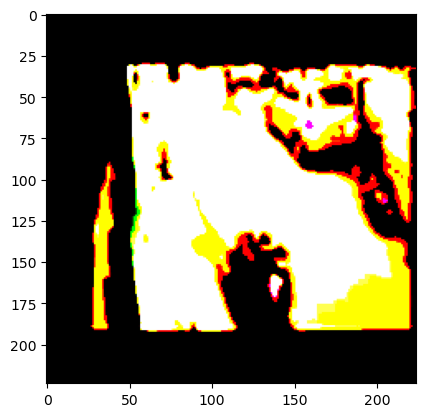

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
Predicted Class: RoadAccidents, Actual Class: Stealing


In [15]:
idx2 = random.randint(0, len(x_test) - 1)
plt.imshow(x_test[idx2])
plt.show()

y_pred = model.predict(x_test[idx2, :].reshape(1, 224, 224, 3))
predicted_class_idx = np.argmax(y_pred)

class_names = sorted([d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))])

predicted_class_name = class_names[predicted_class_idx]
actual_class_name = class_names[np.argmax(y_test[idx2])]

print(f"Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")
